# 毕业设计-算法策略评价代码
### Part01 机器学习算法预测股价
### Part02 基于预测股价的实证、评价
————————————————————————————————————————————————————————————————————

## 机器学习算法预测股价
##### 一、获取真实股价为Y，检查样本完整性
##### 二、不同算法的训练与预测
1. DWT-LSTM
2. LSTM
3. GRU
4. RNN
5. BPNN
6. SVR
##### 三、合并预测结果
+ merge拼接形成真实股价-预测股价数据表

In [1]:
import numpy as np #导入数组模块
import pandas as pd #导入CSV文件
import math #导入数学模块，计算均方根差使用
from matplotlib import pyplot as plt #导入 matplotlib 库中的 pyplot 模块
from tensorflow.keras.models import Sequential #导入 tensorflow 库中的 keras 模块中的 models 子模块中的 Sequential 类
from sklearn.preprocessing import MinMaxScaler #导入 sklearn 库中的 preprocessing 模块中的 MinMaxScaler 类
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Bidirectional #导入 keras 库中的 layers 模块中的 Dense、Activation、Dropout、LSTM 和 Bidirectional 类
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #导入 sklearn 库中的 metrics 模块中的 mean_squared_error、mean_absolute_error 和 r2_score 函数
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR #导入SVR算法模块
from tensorflow.keras.layers import SimpleRNN #利用Keras创建RNN模型模块中的 Dense、SimpleRNN、Dropout 类
# 忽略警告
import warnings 
warnings.filterwarnings('ignore')

#### 一、获取真实股价为Y，检查样本完整性

**获取真实股价**

In [2]:
all_tb = pd.read_csv(r'C:\Users\admin\Desktop\sz50\sz50stocks_front.CSV', encoding = 'gbk') #读取真实行情数据，前复权股价
all_tb.columns = ['code' ,'name', 'date', 'open', 'close', 'high', 'low', 'a', 'b', 'c'] #重新录入表头
all_tb = all_tb.loc[:, ['code' ,'name', 'date', 'close']] #取出真实价格
all_tb['date'] = pd.to_datetime(all_tb['date']) #调整date列数据格式，用于merge

In [5]:
def create(dataset,look_back): #创建训练数据的函数
    # 定义一个名为 create 的函数，该函数接受两个参数：dataset 和 look_back
    dataX = []
    dataY = []
    for i in range(look_back, len(dataset)):
        # 循环从 look_back 开始，到数据集的长度结束
        # look_back 是指用前几个时间步的数据来预测下一个时间步的数据
        dataX.append(dataset[i - look_back:i, 1:])
        # 将当前时间步往前 look_back 个时间步的数据作为输入数据
        # 将这些数据添加到 dataX 列表中
        dataY.append(dataset[i,0])
    # 将当前时间步的目标值（即要预测的下一个时间步的数据）添加到 dataY 列表中
    return np.array(dataX),np.array(dataY)

In [6]:
firm_list = tuple((all_tb.iloc[:, 0]).unique()) #取出公司名
output = [] #用于存储输出数据
for firm in firm_list:
    session = all_tb.query(f"code == '{firm}'")
    session.sort_values(by = 'date', inplace = True) #把时间序列排好
    df_input = session.iloc[:, 3:].replace(np.NaN, 0) #剔除空值
    width = len(df_input.columns) # 获得
    test_split=round(len(df_input)*0.3)    #使用切片操作将 DataFrame 分为训练集和测试集
    df_for_training=df_input[:-test_split]
    df_for_testing=df_input[-test_split:]    #使用 shape 属性获取训练集和测试集的形状，即行数和列数
    look_back = 31    #look_back 是指用前几个时间步的数据来预测下一个时间步的数据
    scaler = MinMaxScaler()    #创建一个 MinMaxScaler 对象，并将特征范围设置为 (0, 1)
    training_scaled = scaler.fit_transform(df_for_training)    #使用 fit_transform() 函数将训练集数据进行缩放，并将结果存储在 training_scaled 变量中
    testing_scaled=scaler.transform(df_for_testing)    #使用 transform() 函数将测试集数据进行缩放，并将结果存储在 testing_scaled 变量中
    trainX,trainY=create(training_scaled,look_back)
    testX,testY=create(testing_scaled,look_back)    #使用 create 函数分别对训练集和测试集进行处理，得到输入数据和目标数据
    original_copies_array = np.repeat(testY, width, axis = -1)
    original = scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),width)))[:,0]
    contr = session.iloc[-len(original):, :3]
    contr['Real_price'] = original
    output.append(contr)
result_Real = pd.concat(output, ignore_index = True)

In [7]:
result_Real

,code,name,date,Real_price
0,600010.SH,包钢股份,2019-11-01,1.36
1,600010.SH,包钢股份,2019-11-04,1.35
2,600010.SH,包钢股份,2019-11-05,1.35
3,600010.SH,包钢股份,2019-11-06,1.33
4,600010.SH,包钢股份,2019-11-07,1.33
...,...,...,...,...
33974,688599.SH,天合光能,2022-12-26,59.36
33975,688599.SH,天合光能,2022-12-27,60.31
33976,688599.SH,天合光能,2022-12-28,62.72
33977,688599.SH,天合光能,2022-12-29,63.20


**检查样本完整性，仅采用有完整样本的个股**

In [8]:
name_list = pd.DataFrame(all_tb['name'].value_counts()).reset_index() #获取各个样本的样本容量

In [9]:
name_list

,index,name
0,包钢股份,2673
1,中国平安,2673
2,航发动力,2673
3,长江电力,2673
4,中远海控,2673
5,中国石化,2673
6,中国神华,2673
7,兴业银行,2673
8,农业银行,2673
9,工商银行,2673


In [10]:
needed_list = tuple(name_list.iloc[:38, 0]) # 仅选择样本完整的个股

#### 二、不同算法的训练与预测


In [11]:
dwt_factors = pd.read_csv(r'C:\Users\admin\Desktop\sz50\dwt_factors.csv', parse_dates = ['date'], index_col = 0) #读取降噪后因子
non_factors = pd.read_csv(r'C:\Users\admin\Desktop\sz50\non_factors.csv', parse_dates = ['date'], index_col = 0) #读取未降噪原始因子

In [12]:
# 提取出在所需个股池中的股票
dwt_factors_needed = dwt_factors[dwt_factors['name'].apply(lambda x: x in needed_list)]
non_factors_needed = non_factors[non_factors['name'].apply(lambda x: x in needed_list)]

**DWT-LSTM模型训练与预测**

In [13]:
firm_list = tuple((dwt_factors_needed.iloc[:, 0]).unique()) # 取出公司名
output = [] #用于存储输出数据
for firm in firm_list:
    session = dwt_factors_needed.query(f"code == '{firm}'")
    session.sort_values(by = 'date', inplace = True) # 把时间序列排好
    df_input = session.iloc[:, 3:].replace(np.NaN, 0) #填补空值
    width = len(df_input.columns)
    test_split=round(len(df_input)*0.3)    #使用切片操作将 DataFrame 分为训练集和测试集
    df_for_training=df_input[:-test_split]
    df_for_testing=df_input[-test_split:]    #分割训练集和测试集
    scaler = MinMaxScaler()    #创建一个 MinMaxScaler 对象，并将特征范围设置为 (0, 1)
    training_scaled = scaler.fit_transform(df_for_training)    #使用 fit_transform() 函数将训练集数据进行缩放，并将结果存储在 training_scaled 变量中
    testing_scaled=scaler.transform(df_for_testing)    #使用 transform() 函数将测试集数据进行缩放，并将结果存储在 testing_scaled 变量中
    look_back = 31    #look_back 是指用前几个时间步的数据来预测下一个时间步的数据
    trainX,trainY=create(training_scaled,look_back)
    testX,testY=create(testing_scaled,look_back)    #使用 create 函数分别对训练集和测试集进行处理，得到输入数据和目标数据
    model = Sequential()  #创建一个序列模型
    model.add((LSTM(units=64, return_sequences=True)))  # 添加一个LSTM层，有64个神经元，返回完整的输出序列
    model.add((LSTM(units=128, return_sequences=False)))  # 添加一个LSTM层，有128个神经元，返回最后的预测值
    model.add(Dropout(0.1))  #添加一个Dropout层，以减少过拟合
    model.add(Dense(1))  # 添加一个全连接层，输出维度为1
    model.add(Activation('relu'))  # 添加一个relu激活函数
    model.compile(loss='mean_squared_error', optimizer='Adam')  # 编译模型，使用均方误差作为损失函数，Adam作为优化器
    # 训练
    history = model.fit(trainX, trainY, batch_size=10, epochs=20, validation_split=None, verbose=2)
    # 预测
    testPredict = model.predict(testX)
    prediction_copies_array = np.repeat(testPredict,width, axis=-1) #将预测得到的Y复制，用于逆归一化
    DWTLSTM_pred_Y = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(testPredict),width)))[:,0] #逆归一化，并取出首列作为预测股价
    contr = session.iloc[-len(testY):, :3] #取出code、name、date列作为基准表，用于拼接预测价格
    contr['DWT-LSTM_pred'] = DWTLSTM_pred_Y[-len(testY):] #将预测价格录入
    output.append(contr)
result_DWTLSTM = pd.concat(output, ignore_index = True)

Epoch 1/20
184/184 - 10s - loss: 0.0063 - 10s/epoch - 53ms/step
Epoch 2/20
184/184 - 3s - loss: 0.0021 - 3s/epoch - 14ms/step
Epoch 3/20
184/184 - 3s - loss: 0.0020 - 3s/epoch - 14ms/step
Epoch 4/20
184/184 - 3s - loss: 0.0014 - 3s/epoch - 14ms/step
Epoch 5/20
184/184 - 3s - loss: 0.0014 - 3s/epoch - 14ms/step
Epoch 6/20
184/184 - 3s - loss: 0.0011 - 3s/epoch - 14ms/step
Epoch 7/20
184/184 - 3s - loss: 0.0011 - 3s/epoch - 14ms/step
Epoch 8/20
184/184 - 3s - loss: 0.0011 - 3s/epoch - 14ms/step
Epoch 9/20
184/184 - 3s - loss: 0.0010 - 3s/epoch - 14ms/step
Epoch 10/20
184/184 - 3s - loss: 8.9412e-04 - 3s/epoch - 14ms/step
Epoch 11/20
184/184 - 3s - loss: 7.5512e-04 - 3s/epoch - 14ms/step
Epoch 12/20
184/184 - 3s - loss: 8.2804e-04 - 3s/epoch - 14ms/step
Epoch 13/20
184/184 - 3s - loss: 8.6561e-04 - 3s/epoch - 14ms/step
Epoch 14/20
184/184 - 3s - loss: 7.6960e-04 - 3s/epoch - 14ms/step
Epoch 15/20
184/184 - 3s - loss: 6.2945e-04 - 3s/epoch - 14ms/step
Epoch 16/20
184/184 - 3s - loss: 7.388

In [14]:
result_DWTLSTM

,code,name,date,DWTLSTM_pred
0,600010.SH,包钢股份,2019-11-01,1.230000
1,600010.SH,包钢股份,2019-11-04,1.230000
2,600010.SH,包钢股份,2019-11-05,1.230000
3,600010.SH,包钢股份,2019-11-06,1.230000
4,600010.SH,包钢股份,2019-11-07,1.230000
...,...,...,...,...
29293,601919.SH,中远海控,2022-12-26,9.943408
29294,601919.SH,中远海控,2022-12-27,9.747062
29295,601919.SH,中远海控,2022-12-28,9.772141
29296,601919.SH,中远海控,2022-12-29,9.772343


#### LSTM模型训练与预测

In [15]:
firm_list = tuple((non_factors_needed.iloc[:, 0]).unique()) # 取出公司名
output = [] #用于存储输出数据
for firm in firm_list:
    session = non_factors_needed.query(f"code == '{firm}'")
    session.sort_values(by = 'date', inplace = True) # 把时间序列排好
    df_input = session.iloc[:, 3:].replace(np.NaN, 0)
    width = len(df_input.columns)
    test_split=round(len(df_input)*0.3)    #使用切片操作将 DataFrame 分为训练集和测试集
    df_for_training=df_input[:-test_split]
    df_for_testing=df_input[-test_split:]    #分割训练集和测试集
    scaler = MinMaxScaler()    #创建一个 MinMaxScaler 对象，并将特征范围设置为 (0, 1)
    training_scaled = scaler.fit_transform(df_for_training)    #使用 fit_transform() 函数将训练集数据进行缩放，并将结果存储在 training_scaled 变量中
    testing_scaled=scaler.transform(df_for_testing)    #使用 transform() 函数将测试集数据进行缩放，并将结果存储在 testing_scaled 变量中
    look_back = 31    #look_back 是指用前几个时间步的数据来预测下一个时间步的数据
    trainX,trainY=create(training_scaled,look_back)
    testX,testY=create(testing_scaled,look_back)    #使用 create 函数分别对训练集和测试集进行处理，得到输入数据和目标数据
    model = Sequential()  # 创建一个序列模型
    model.add((LSTM(units=64, return_sequences = False)))  #添加一个LSTM层，有64个神经元，返回完整的输出序列
    #model.add((LSTM(units=128, return_sequences=False)))  #添加一个LSTM层，有128个神经元，返回最后的预测值
    model.add(Dropout(0.1))  #添加一个Dropout层，以减少过拟合
    model.add(Dense(1))  #添加一个全连接层，输出维度为1
    model.add(Activation('relu'))  #添加一个tanh激活函数
    model.compile(loss='mean_squared_error', optimizer='Adam')  #编译模型，使用均方误差作为损失函数，Adam作为优化器
    # 训练
    history = model.fit(trainX, trainY, batch_size=10, epochs=20, validation_split=None, verbose=2)
    # 预测
    testPredict = model.predict(testX) 
    prediction_copies_array = np.repeat(testPredict,width, axis=-1) #将预测得到的Y复制，用于逆归一化
    LSTM_pred_Y = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(testPredict),width)))[:,0] #逆归一化，并取出首列作为预测股价
    contr = session.iloc[-len(testY):, :3] #取出code、name、date列作为基准表，用于拼接预测价格
    contr['LSTM_pred'] = LSTM_pred_Y[-len(testY):] #将预测价格录入
    output.append(contr)
result_LSTM = pd.concat(output, ignore_index = True)

Epoch 1/20
184/184 - 4s - loss: 0.0830 - 4s/epoch - 24ms/step
Epoch 2/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 3/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 4/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 5/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 6/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 7/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 8/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 9/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 10/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 10ms/step
Epoch 11/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 12/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 13/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 14/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 15/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 16/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 17/20
184

In [16]:
result_LSTM

,code,name,date,LSTM_pred
0,600010.SH,包钢股份,2019-11-01,1.422633
1,600010.SH,包钢股份,2019-11-04,1.385118
2,600010.SH,包钢股份,2019-11-05,1.416065
3,600010.SH,包钢股份,2019-11-06,1.425029
4,600010.SH,包钢股份,2019-11-07,1.411870
...,...,...,...,...
29293,601919.SH,中远海控,2022-12-26,9.192985
29294,601919.SH,中远海控,2022-12-27,9.184710
29295,601919.SH,中远海控,2022-12-28,9.188065
29296,601919.SH,中远海控,2022-12-29,9.152113


**GRU模型训练与预测**

In [17]:
firm_list = tuple((non_factors_needed.iloc[:, 0]).unique()) # 取出公司名
output = [] # 用于存储输出数据
for firm in firm_list:
    session = non_factors_needed.query(f"code == '{firm}'")
    session.sort_values(by = 'date', inplace = True) # 把时间序列排好
    df_input = session.iloc[:, 3:].replace(np.NaN, 0) #填补空值
    width = len(df_input.columns)
    test_split=round(len(df_input)*0.3)    #使用切片操作将 DataFrame 分为训练集和测试集
    df_for_training=df_input[:-test_split]
    df_for_testing=df_input[-test_split:]    #分割训练集和测试集
    scaler = MinMaxScaler()    #创建一个 MinMaxScaler 对象，并将特征范围设置为 (0, 1)
    training_scaled = scaler.fit_transform(df_for_training)    #使用 fit_transform() 函数将训练集数据进行缩放，并将结果存储在 training_scaled 变量中
    testing_scaled=scaler.transform(df_for_testing)    #使用 transform() 函数将测试集数据进行缩放，并将结果存储在 testing_scaled 变量中
    look_back = 31    #look_back 是指用前几个时间步的数据来预测下一个时间步的数据
    trainX,trainY=create(training_scaled,look_back)
    testX,testY=create(testing_scaled,look_back)    #使用 create 函数分别对训练集和测试集进行处理，得到输入数据和目标数据
    sample = trainX
    input_shape = sample[0].shape[-2:]
    
    model = Sequential()  #创建一个序列模型
    model.add((GRU(units=64, return_sequences=False)))  #添加一个GRU层，有64个神经元，返回完整的输出序列
    model.add(Dropout(0.1))  #添加一个Dropout层，以减少过拟合
    model.add(Dense(1))  # 添加一个全连接层，输出维度为1
    model.add(Activation('relu'))  #添加一个tanh激活函数
    model.compile(loss='mean_squared_error', optimizer='Adam')  #编译模型，使用均方误差作为损失函数，Adam作为优化器
    # 训练
    history = model.fit(trainX, trainY, batch_size=10, epochs=20, validation_split=None, verbose=2)
    # 预测
    testPredict = model.predict(testX)
    prediction_copies_array = np.repeat(testPredict,width, axis=-1) #将预测得到的Y复制，用于逆归一化
    GRU_pred_Y = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(testPredict),width)))[:,0] #逆归一化，并取出首列作为预测股价
    contr = session.iloc[-len(testY):, :3] #取出code、name、date列作为基准表，用于拼接预测价格
    contr['GRU_pred'] = GRU_pred_Y[-len(testY):] #将预测价格录入
    output.append(contr)
result_GRU = pd.concat(output, ignore_index = True)

Epoch 1/20
184/184 - 4s - loss: 0.0823 - 4s/epoch - 22ms/step
Epoch 2/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 3/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 8ms/step
Epoch 4/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 8ms/step
Epoch 5/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 8ms/step
Epoch 6/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 8ms/step
Epoch 7/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 8ms/step
Epoch 8/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 8ms/step
Epoch 9/20
184/184 - 1s - loss: 0.0825 - 1s/epoch - 8ms/step
Epoch 10/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 11/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 9ms/step
Epoch 12/20
184/184 - 1s - loss: 0.0825 - 1s/epoch - 8ms/step
Epoch 13/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 8ms/step
Epoch 14/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 8ms/step
Epoch 15/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 8ms/step
Epoch 16/20
184/184 - 2s - loss: 0.0825 - 2s/epoch - 8ms/step
Epoch 17/20
184/

In [18]:
result_GRU

,code,name,date,GRU_pred
0,600010.SH,包钢股份,2019-11-01,1.430432
1,600010.SH,包钢股份,2019-11-04,1.457342
2,600010.SH,包钢股份,2019-11-05,1.475237
3,600010.SH,包钢股份,2019-11-06,1.479558
4,600010.SH,包钢股份,2019-11-07,1.460716
...,...,...,...,...
29293,601919.SH,中远海控,2022-12-26,10.801550
29294,601919.SH,中远海控,2022-12-27,10.479749
29295,601919.SH,中远海控,2022-12-28,10.731257
29296,601919.SH,中远海控,2022-12-29,10.515536


**RNN模型训练与预测**

In [19]:
firm_list = tuple((non_factors_needed.iloc[:, 0]).unique()) # 取出公司名
output = [] # 用于存储输出数据
for firm in firm_list:
    session = non_factors_needed.query(f"code == '{firm}'")
    session.sort_values(by = 'date', inplace = True) # 把时间序列排好
    df_input = session.iloc[:, 3:].replace(np.NaN, 0)
    width = len(df_input.columns)
    test_split=round(len(df_input)*0.3)    #使用切片操作将 DataFrame 分为训练集和测试集
    df_for_training=df_input[:-test_split]
    df_for_testing=df_input[-test_split:]    #使用 shape 属性获取训练集和测试集的形状，即行数和列数
    scaler = MinMaxScaler()    #创建一个 MinMaxScaler 对象，并将特征范围设置为 (0, 1)
    training_scaled = scaler.fit_transform(df_for_training)    #使用 fit_transform() 函数将训练集数据进行缩放，并将结果存储在 training_scaled 变量中
    testing_scaled=scaler.transform(df_for_testing)    #使用 transform() 函数将测试集数据进行缩放，并将结果存储在 testing_scaled 变量中
    look_back = 31    #look_back 是指用前几个时间步的数据来预测下一个时间步的数据
    trainX,trainY=create(training_scaled,look_back)
    testX,testY=create(testing_scaled,look_back)    #使用 create 函数分别对训练集和测试集进行处理，得到输入数据和目标数据
    # 初始化顺序模型
    regressor = Sequential()
    # 定义输入层及带32个神经元的隐藏层
    regressor.add(SimpleRNN(units = 32))
    # 定义线性的输出层
    regressor.add(Dense(1))
    model.add(Activation('relu'))  # 添加一个ReLU激活函数
    # 模型编译：定义优化算法adam， 目标函数均方根MSE
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # 模型训练
    history = regressor.fit(trainX, trainY, epochs = 20, batch_size = 10, verbose = 2)
    # 预测
    testPredict = regressor.predict(testX)
    prediction_copies_array = np.repeat(testPredict,width, axis=-1)
    RNN_pred_Y = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(testPredict),width)))[:,0]
    contr = session.iloc[-len(testY):, :3]
    contr['RNN_pred'] = RNN_pred_Y[-len(testY):]
    output.append(contr)
result_RNN = pd.concat(output, ignore_index = True)

Epoch 1/20
184/184 - 9s - loss: 0.0338 - 9s/epoch - 48ms/step
Epoch 2/20
184/184 - 7s - loss: 0.0063 - 7s/epoch - 38ms/step
Epoch 3/20
184/184 - 8s - loss: 0.0034 - 8s/epoch - 46ms/step
Epoch 4/20
184/184 - 8s - loss: 0.0023 - 8s/epoch - 43ms/step
Epoch 5/20
184/184 - 8s - loss: 0.0019 - 8s/epoch - 41ms/step
Epoch 6/20
184/184 - 7s - loss: 0.0016 - 7s/epoch - 39ms/step
Epoch 7/20
184/184 - 8s - loss: 0.0015 - 8s/epoch - 41ms/step
Epoch 8/20
184/184 - 8s - loss: 0.0014 - 8s/epoch - 44ms/step
Epoch 9/20
184/184 - 8s - loss: 0.0013 - 8s/epoch - 45ms/step
Epoch 10/20
184/184 - 9s - loss: 0.0011 - 9s/epoch - 47ms/step
Epoch 11/20
184/184 - 8s - loss: 9.5415e-04 - 8s/epoch - 41ms/step
Epoch 12/20
184/184 - 7s - loss: 9.2104e-04 - 7s/epoch - 40ms/step
Epoch 13/20
184/184 - 7s - loss: 8.7277e-04 - 7s/epoch - 40ms/step
Epoch 14/20
184/184 - 8s - loss: 7.8315e-04 - 8s/epoch - 41ms/step
Epoch 15/20
184/184 - 8s - loss: 7.4731e-04 - 8s/epoch - 45ms/step
Epoch 16/20
184/184 - 7s - loss: 9.8570e-04 

In [20]:
result_RNN

,code,name,date,RNN_pred
0,600010.SH,包钢股份,2019-11-01,1.396972
1,600010.SH,包钢股份,2019-11-04,1.361656
2,600010.SH,包钢股份,2019-11-05,1.322403
3,600010.SH,包钢股份,2019-11-06,1.330086
4,600010.SH,包钢股份,2019-11-07,1.276109
...,...,...,...,...
29293,601919.SH,中远海控,2022-12-26,10.577143
29294,601919.SH,中远海控,2022-12-27,10.329845
29295,601919.SH,中远海控,2022-12-28,10.498543
29296,601919.SH,中远海控,2022-12-29,10.340811


**BPNN模型训练与预测**

In [21]:
firm_list = tuple((non_factors_needed.iloc[:, 0]).unique()) # 取出公司名
output = [] # 用于存储输出数据
for firm in firm_list:
    session = non_factors_needed.query(f"code == '{firm}'")
    session.sort_values(by = 'date', inplace = True) # 把时间序列排好
    df_input = session.iloc[:, 3:].replace(np.NaN, 0)
    input_max = df_input.max()
    input_min = df_input.min()
    df_input = (df_input - input_min)/(input_max - input_min)
    X=df_input.iloc[:,1:]
    y=df_input.iloc[:,0]#切片是前闭后开[)
    cut=round(len(y)*0.7)
    X_train, X_test=X.iloc[:(cut-1)].replace(np.NaN, 0),X.iloc[cut:len(X)-1].replace(np.NaN, 0)#列表的切片操作，X.iloc[0:2400，0:7]即为1-2400行，1-7列
    y_train, y_test=y.iloc[1:cut].replace(np.NaN, 0),y.iloc[(cut+1):].replace(np.NaN, 0)
    X_train,X_test,y_train,y_test=X_train.values,X_test.values,y_train.values,y_test.values
    model = Sequential()  #层次模型
    model.add(Dense(64)) #输入层，Dense表示BP层
    model.add(Activation('relu'))  #添加激活函数
    model.add(Dense(1))  #输出层
    model.compile(loss='mean_squared_error', optimizer='Adam') #编译模型
    model.fit(X_train, y_train, epochs = 50, batch_size = 10) #训练模型1000次
    y_test_predict=model.predict(X_test)
    BPNN_pred_Y = y_test_predict[:, 0]*(input_max['close']-input_min['close'])+input_min['close']
    contr = session.iloc[-len(y_test):, :3]
    contr['BPNN_pred'] = BPNN_pred_Y[-len(y_test):]
    output.append(contr)
result_BPNN = pd.concat(output, ignore_index = True)

Epoch 1/50
187/187 [==============================] - 2s 6ms/step - loss: 0.0111
Epoch 2/50
187/187 [==============================] - 1s 5ms/step - loss: 0.0025
Epoch 3/50
187/187 [==============================] - 1s 6ms/step - loss: 0.0013
Epoch 4/50
187/187 [==============================] - 1s 6ms/step - loss: 0.0012
Epoch 5/50
187/187 [==============================] - 1s 5ms/step - loss: 7.3592e-04
Epoch 6/50
187/187 [==============================] - 1s 6ms/step - loss: 7.0233e-04
Epoch 7/50
187/187 [==============================] - 1s 6ms/step - loss: 6.7711e-04
Epoch 8/50
187/187 [==============================] - 1s 6ms/step - loss: 6.2733e-04
Epoch 9/50
187/187 [==============================] - 1s 6ms/step - loss: 5.6318e-04
Epoch 10/50
187/187 [==============================] - 1s 6ms/step - loss: 6.0422e-04
Epoch 11/50
187/187 [==============================] - 1s 5ms/step - loss: 5.4189e-04
Epoch 12/50
187/187 [==============================] - 1s 6ms/step - loss: 6.52

In [22]:
result_BPNN

,code,name,date,BPNN_pred
0,600010.SH,包钢股份,2019-11-01,1.303344
1,600010.SH,包钢股份,2019-11-04,1.293462
2,600010.SH,包钢股份,2019-11-05,1.280757
3,600010.SH,包钢股份,2019-11-06,1.280779
4,600010.SH,包钢股份,2019-11-07,1.265725
...,...,...,...,...
29293,601919.SH,中远海控,2022-12-26,10.765028
29294,601919.SH,中远海控,2022-12-27,10.479748
29295,601919.SH,中远海控,2022-12-28,10.556759
29296,601919.SH,中远海控,2022-12-29,10.484646


**SVR模型训练与预测**

In [23]:
firm_list = tuple((non_factors_needed.iloc[:, 0]).unique()) # 取出公司名
output = [] # 用于存储输出数据
for firm in firm_list:
    session = non_factors_needed.query(f"code == '{firm}'")
    session.sort_values(by = 'date', inplace = True) # 把时间序列排好
    df_input = session.iloc[:, 3:].replace(np.NaN, 0)
    input_max = df_input.max()
    input_min = df_input.min()
    df_input = (df_input - input_min)/(input_max - input_min)
    X=df_input.iloc[:,1:]
    y=df_input.iloc[:,0]#切片是前闭后开[)
    cut=round(len(y)*0.7)
    X_train, X_test=X.iloc[:(cut-1)].replace(np.NaN, 0),X.iloc[cut:len(X)-1].replace(np.NaN, 0)#列表的切片操作，X.iloc[0:2400，0:7]即为1-2400行，1-7列
    y_train, y_test=y.iloc[1:cut].replace(np.NaN, 0),y.iloc[(cut+1):].replace(np.NaN, 0)
    X_train,X_test,y_train,y_test=X_train.values,X_test.values,y_train.values,y_test.values
    model_SVR = SVR(kernel='linear', C=1.25)
    model_SVR.fit(X_train, y_train)
    y_test_predict=model_SVR.predict(X_test)
    SVR_pred_Y = y_test_predict*(input_max['close']-input_min['close'])+input_min['close']
    contr = session.iloc[-len(y_test):, :3]
    contr['SVR_pred'] = SVR_pred_Y[-len(y_test):]
    output.append(contr)
result_SVR = pd.concat(output, ignore_index = True)

In [24]:
result_SVR

,code,name,date,SVR_pred
0,600010.SH,包钢股份,2019-11-01,1.785533
1,600010.SH,包钢股份,2019-11-04,1.704521
2,600010.SH,包钢股份,2019-11-05,1.691270
3,600010.SH,包钢股份,2019-11-06,1.692336
4,600010.SH,包钢股份,2019-11-07,1.662204
...,...,...,...,...
29293,601919.SH,中远海控,2022-12-26,9.194444
29294,601919.SH,中远海控,2022-12-27,9.086353
29295,601919.SH,中远海控,2022-12-28,9.045256
29296,601919.SH,中远海控,2022-12-29,9.030020


#### 汇总预测结果

In [25]:
# 将所有算法的预测结果拼接在一起
contr_all = result_DWTLSTM.merge(result_LSTM, on = ['code', 'name', 'date'])
contr_all = contr_all.merge(result_GRU, on = ['code', 'name', 'date'])
contr_all = contr_all.merge(result_RNN, on = ['code', 'name', 'date'])
contr_all = contr_all.merge(result_BPNN, on = ['code', 'name', 'date'])
contr_all = contr_all.merge(result_SVR, on = ['code', 'name', 'date'])

In [26]:
contr_all = contr_all.merge(all_tb, on = ['code', 'name', 'date']) #拼接真实股价

In [27]:
contr_all

,code,name,date,DWTLSTM_pred,LSTM_pred,GRU_pred,RNN_pred,BPNN_pred,SVR_pred,close
0,600010.SH,包钢股份,2019-11-01,1.230000,1.422633,1.430432,1.396972,1.303344,1.785533,1.36
1,600010.SH,包钢股份,2019-11-04,1.230000,1.385118,1.457342,1.361656,1.293462,1.704521,1.35
2,600010.SH,包钢股份,2019-11-05,1.230000,1.416065,1.475237,1.322403,1.280757,1.691270,1.35
3,600010.SH,包钢股份,2019-11-06,1.230000,1.425029,1.479558,1.330086,1.280779,1.692336,1.33
4,600010.SH,包钢股份,2019-11-07,1.230000,1.411870,1.460716,1.276109,1.265725,1.662204,1.33
...,...,...,...,...,...,...,...,...,...,...
29293,601919.SH,中远海控,2022-12-26,9.943408,9.192985,10.801550,10.577143,10.765028,9.194444,10.40
29294,601919.SH,中远海控,2022-12-27,9.747062,9.184710,10.479749,10.329845,10.479748,9.086353,10.48
29295,601919.SH,中远海控,2022-12-28,9.772141,9.188065,10.731257,10.498543,10.556759,9.045256,10.40
29296,601919.SH,中远海控,2022-12-29,9.772343,9.152113,10.515536,10.340811,10.484646,9.030020,10.14


## 基于预测股价的实证结构
##### 一、股价预测性能测试
1. RMSE
2. MAE
##### 二、涨跌预测性能测试
1. 预测涨跌
2. 标记涨跌预测的二分类结果
3. Accuracy
4. Precision
5. Recall
##### 三、策略回测
1. 市场组合收益走势
2. 根据涨跌构建投资组合
3. 绘制累计收益率走势
##### 四、策略收益评价
1. 年化收益率
2. 最大回测率
3. Sharpe Ratio
4. 胜率
5. Alpha
6. Beta

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math #导入需要的库

In [32]:
contr_all = contr_all[contr_all['date']>='2020-4-1'][contr_all['date']<='2022-4-1'] #切片，取出回测区间的预测价格数据

In [33]:
contr_all

,code,name,date,DWTLSTM_pred,LSTM_pred,GRU_pred,RNN_pred,BPNN_pred,SVR_pred,close
101,600010.SH,包钢股份,2020-04-01,1.230000,1.270462,1.241758,1.154127,1.117819,1.481056,1.13
102,600010.SH,包钢股份,2020-04-02,1.230000,1.267330,1.232713,1.215704,1.105387,1.506650,1.14
103,600010.SH,包钢股份,2020-04-03,1.230000,1.271390,1.230000,1.220739,1.086620,1.521000,1.13
104,600010.SH,包钢股份,2020-04-07,1.230000,1.269136,1.235760,1.138142,1.104431,1.428441,1.15
105,600010.SH,包钢股份,2020-04-08,1.230000,1.286038,1.242225,1.198265,1.138982,1.428034,1.14
...,...,...,...,...,...,...,...,...,...,...
29110,601919.SH,中远海控,2022-03-28,11.498196,9.434524,12.354527,12.204664,12.559548,10.461216,12.52
29111,601919.SH,中远海控,2022-03-29,11.202183,9.489774,12.455503,12.094257,12.505135,10.190945,12.82
29112,601919.SH,中远海控,2022-03-30,11.532965,9.470687,12.958539,12.457719,12.824050,10.459849,12.81
29113,601919.SH,中远海控,2022-03-31,11.596363,9.484496,12.677312,12.335800,12.802717,10.516524,12.34


### 一、股价预测的性能评价

#### 1. RMSE

In [34]:
method_list = ['DWTLSTM', 'LSTM', 'GRU', 'RNN', 'BPNN', 'SVR'] #设定循环list，用于后续计算各算法的精准度
stock_list = tuple(contr_all['name'].unique()) #取得所有个股名单
output = []
for name in stock_list:
    session = contr_all.query(f"name == '{name}'") #切片取出个股预测股价数据
    session.sort_values(by = 'date', ascending = True, inplace = True) #按时间从前到后排序
    out = []
    for method in method_list: #循环计算该个股的每个算法的预测情况
        RMSE = math.sqrt(mean_squared_error(session['close'], session[f'{method}_pred'])) #计算RMSE指标
        out.append(RMSE)
    RMSE_df = pd.DataFrame(out, index = ['DWTLSTM', 'LSTM', 'GRU', 'RNN', 'BPNN', 'SVR'], columns = [f'{name}']).T #汇总各算法预测情况到一张表
    RMSE_df.reset_index(inplace = True)
    output.append(RMSE_df)
RMSE_summary = pd.concat(output, ignore_index = True)

In [35]:
RMSE_summary.iloc[:, 1:] = RMSE_summary.iloc[:, 1:].apply(lambda x: round(x, 4)) #精确度取到小数点后四位

In [36]:
RMSE_summary

,index,DWTLSTM,LSTM,GRU,RNN,BPNN,SVR
0,包钢股份,0.9661,0.1332,0.1139,0.1086,0.0944,0.2446
1,中国石化,0.0576,0.0530,0.0716,0.0546,0.0605,0.0518
2,中信证券,0.6164,0.7768,0.5358,0.5123,0.5763,0.5335
3,三一重工,6.6166,13.1524,2.5603,5.6823,2.9586,14.8579
4,招商银行,4.3772,12.0948,1.0298,2.3685,1.9473,7.3765
5,保利发展,0.4282,0.9327,0.4611,0.3268,0.3235,0.7906
6,上汽集团,0.6233,0.5118,12.4842,0.4500,0.4427,0.5192
7,北方稀土,4.4344,10.3032,1.9962,1.8286,1.2436,8.0420
8,复星医药,3.0576,11.5288,44.7892,2.1218,3.9993,9.0896
9,恒瑞医药,5.1373,17.1471,1.9541,2.2052,1.5706,11.8750


In [38]:
# 输出RMSE评价结果
RMSE_summary.to_excel(r'C:\Users\admin\Desktop\sz50\0520\RMSE_adjusted_0520.xlsx')

#### 2. MAE

In [39]:
method_list = ['DWTLSTM', 'LSTM', 'GRU', 'RNN', 'BPNN', 'SVR'] #设定循环list，用于后续计算各算法的精准度
stock_list = tuple(contr_all['name'].unique()) #取得所有个股名单
output = []
for name in stock_list:
    session = contr_all.query(f"name == '{name}'") #切片取出个股预测股价数据
    session.sort_values(by = 'date', ascending = True, inplace = True) #按时间从前到后排序
    out = []
    for method in method_list:
        MAE = mean_absolute_error(session['close'], session[f'{method}_pred']) #计算MAE指标
        out.append(MAE)
    MAE_df = pd.DataFrame(out, index = ['DWTLSTM', 'LSTM', 'GRU', 'RNN', 'BPNN', 'SVR'], columns = [f'{name}']).T #汇总各算法预测情况到一张表
    MAE_df.reset_index(inplace = True)
    output.append(MAE_df)
MAE_summary = pd.concat(output, ignore_index = True)

In [40]:
MAE_summary.iloc[:, 1:] = MAE_summary.iloc[:, 1:].apply(lambda x: round(x, 4)) #精确度取到小数点后四位

In [41]:
MAE_summary

,index,DWTLSTM,LSTM,GRU,RNN,BPNN,SVR
0,包钢股份,0.6661,0.1130,0.0942,0.0774,0.0666,0.2210
1,中国石化,0.0429,0.0364,0.0568,0.0383,0.0456,0.0370
2,中信证券,0.4630,0.6452,0.3657,0.3554,0.4140,0.3661
3,三一重工,5.1426,11.4846,1.6874,3.8238,2.5356,13.8254
4,招商银行,3.6938,10.2741,0.8327,1.9479,1.5957,6.9663
5,保利发展,0.3116,0.7322,0.3583,0.2350,0.2332,0.6788
6,上汽集团,0.4421,0.3728,12.3102,0.3042,0.3080,0.3807
7,北方稀土,2.8400,6.1924,1.2343,1.1056,0.7933,6.2017
8,复星医药,2.0860,8.0741,43.3031,1.4627,2.7057,7.9052
9,恒瑞医药,3.9766,13.4643,1.4138,1.6570,1.1443,10.7637


In [42]:
# 输出MAE评价结果
MAE_summary.to_excel(r'C:\Users\admin\Desktop\sz50\0520\MAE_adjusted_0520.xlsx')

### 二、涨跌预测性能评价

#### 1. 预测下一日涨跌情况

In [43]:
# 根据预测的股价，预测下一日的涨跌情况
method_list = ['DWTLSTM', 'LSTM', 'GRU', 'RNN', 'BPNN', 'SVR'] #设定循环list，用于后续保存各算法的涨跌预测情况
stock_name = tuple(contr_all['name'].unique()) #取出所有个股名单
output = []
for name in stock_name:
    session = (contr_all.query(f"name == '{name}'")) #切片，取出单个个股的预测股价数据
    session.sort_values(by = 'date', ascending = True, inplace = True) #按时间前后排序
    change_df = copy.deepcopy(session.iloc[:, 0:3])
    change_df['Real_change'] =  (session['close'] - session['close'].shift(1)).apply(lambda x: 'up' if x > 0 else 'down') #标记真实涨跌，后前两日价差为证则涨；反之则跌
    for method in method_list:
        # 标记预测的涨跌，后前两日价差为证则涨；反之则跌。
        change_df[f'{method}_change_pred'] = (session[f'{method}_pred'] - session[f'{method}_pred'].shift(1)).apply(lambda x: 'up' if x > 0 else 'down') 
    output.append(change_df)
change_tb = pd.concat(output, ignore_index = True)

In [44]:
change_tb

,code,name,date,Real_change,DWTLSTM_change_pred,LSTM_change_pred,GRU_change_pred,RNN_change_pred,BPNN_change_pred,SVR_change_pred
0,600010.SH,包钢股份,2020-04-01,down,down,down,down,down,down,down
1,600010.SH,包钢股份,2020-04-02,up,down,down,down,up,down,up
2,600010.SH,包钢股份,2020-04-03,down,down,up,down,up,down,up
3,600010.SH,包钢股份,2020-04-07,up,down,down,up,down,up,down
4,600010.SH,包钢股份,2020-04-08,down,down,up,up,up,up,down
...,...,...,...,...,...,...,...,...,...,...
18501,601919.SH,中远海控,2022-03-28,down,down,down,down,down,down,down
18502,601919.SH,中远海控,2022-03-29,up,down,up,up,down,down,down
18503,601919.SH,中远海控,2022-03-30,down,up,down,up,up,up,up
18504,601919.SH,中远海控,2022-03-31,down,up,up,down,down,down,up


#### 2. 标记二分类结果，构建混淆矩阵

In [45]:
def label(method, stock, tb): #定义预测准确情况，二分类问题
    summary = []
    calc = tb.loc[:, [f'{method}_change_pred', 'Real_change']]
    for i in range(len(calc)):
        session = calc.iloc[i, :]
        if (session[f'{method}_change_pred'] == 'up')&(session['Real_change'] == 'up'): #预测和实际都上涨，则标记为TU
            result = 'TU'
        elif (session[f'{method}_change_pred'] == 'up')&(session['Real_change'] == 'down'): #预测上涨但实际下跌，标记为FDU
            result = 'FDU'
        elif (session[f'{method}_change_pred'] == 'down')&(session['Real_change'] == 'up'): #预测下跌但实际上张，标记为FUD
            result = 'FUD'
        else:
            result = 'TD' #预测和实际都下跌，标记为TD
        summary.append(result)
    result_df = pd.DataFrame(pd.Series(summary).value_counts(), columns = [f'{stock}']).T #将个股统计结果转换为整表
    return result_df

In [46]:
# 标记DWTLSTM的混淆矩阵
change_tb_DWTLSTM = change_tb.loc[:, ['code', 'name', 'date', 'DWTLSTM_change_pred', 'Real_change']] #取出需要的表头
stock_list = tuple(change_tb_DWTLSTM['name'].unique()) #获得所有个股名单
output = []
for name in stock_list:
    session = change_tb_DWTLSTM.query(f"name == '{name}'") #切片，提取单个个股
    out = label('DWTLSTM', f'{name}', session).reset_index() #统计该股票的涨跌准确情况分布
    output.append(out)
DWTLSTM_hunxiao = pd.concat(output, ignore_index = True) #将所有个股情况拼接在一起

In [47]:
DWTLSTM_hunxiao

,index,TD,FUD,FDU,TU
0,包钢股份,125,110,113.0,139.0
1,中国石化,146,97,130.0,114.0
2,中信证券,138,101,126.0,122.0
3,三一重工,124,123,121.0,119.0
4,招商银行,140,91,116.0,140.0
5,保利发展,156,109,100.0,122.0
6,上汽集团,143,116,121.0,107.0
7,北方稀土,131,104,107.0,145.0
8,复星医药,121,127,116.0,123.0
9,恒瑞医药,142,122,114.0,109.0


**LSTM的混淆矩阵**

In [48]:
change_tb_LSTM = change_tb.loc[:, ['code', 'name', 'date', 'LSTM_change_pred', 'Real_change']] #取出需要的表头
stock_list = tuple(change_tb_LSTM['name'].unique()) #获得所有个股名单
output = []
for name in stock_list:
    session = change_tb_LSTM.query(f"name == '{name}'") #切片，提取单个个股
    out = label('LSTM', f'{name}', session).reset_index() #标记该个股预测情况
    output.append(out)
LSTM_hunxiao = pd.concat(output, ignore_index = True) #将所有个股情况拼接在一起

In [49]:
LSTM_hunxiao

,index,FDU,TD,FUD,TU
0,包钢股份,144,152,86,105
1,中国石化,130,146,100,111
2,中信证券,117,147,109,114
3,三一重工,107,138,101,141
4,招商银行,120,136,100,131
5,保利发展,113,143,119,112
6,上汽集团,111,153,117,106
7,北方稀土,115,123,100,149
8,复星医药,114,123,132,118
9,恒瑞医药,125,131,132,99


* 调整结果

**GRU的混淆矩阵**

In [50]:
change_tb_GRU = change_tb.loc[:, ['code', 'name', 'date', 'GRU_change_pred', 'Real_change']] #取出需要的表头
stock_list = tuple(change_tb_GRU['name'].unique()) #获得所有个股名单
output = []
for name in stock_list:
    session = change_tb_GRU.query(f"name == '{name}'") #切片，提取单个个股
    out = label('GRU', f'{name}', session).reset_index() #标记该个股预测情况
    output.append(out)
GRU_hunxiao = pd.concat(output, ignore_index = True) #将所有个股情况拼接在一起

* 调整结果

In [51]:
GRU_hunxiao

,index,TD,FDU,FUD,TU
0,包钢股份,177,119.0,101,90.0
1,中国石化,137,139.0,112,99.0
2,中信证券,146,118.0,103,120.0
3,三一重工,139,106.0,113,129.0
4,招商银行,146,110.0,110,121.0
5,保利发展,146,110.0,117,114.0
6,上汽集团,132,124.0,124,115.0
7,北方稀土,124,114.0,112,137.0
8,复星医药,114,124.0,123,126.0
9,恒瑞医药,135,121.0,121,110.0


**RNN的混淆矩阵**

In [52]:
change_tb_RNN = change_tb.loc[:, ['code', 'name', 'date', 'RNN_change_pred', 'Real_change']] #取出需要的表头
stock_list = tuple(change_tb_RNN['name'].unique()) #获得所有个股名单
output = []
for name in stock_list:
    session = change_tb_RNN.query(f"name == '{name}'") #切片，提取单个个股
    out = label('RNN', f'{name}', session).reset_index() #标记该个股预测情况
    output.append(out)
RNN_hunxiao = pd.concat(output, ignore_index = True) #将所有个股情况拼接在一起

In [53]:
RNN_hunxiao

,index,TD,FDU,TU,FUD
0,包钢股份,166,130,112,79
1,中国石化,136,140,107,104
2,中信证券,152,112,109,114
3,三一重工,129,116,127,115
4,招商银行,138,118,120,111
5,保利发展,140,116,122,109
6,上汽集团,140,124,103,120
7,北方稀土,121,117,138,111
8,复星医药,129,108,118,132
9,恒瑞医药,129,127,107,124


**BPNN的混淆矩阵**

In [54]:
change_tb_BPNN = change_tb.loc[:, ['code', 'name', 'date', 'BPNN_change_pred', 'Real_change']] #取出需要的表头
stock_list = tuple(change_tb_BPNN['name'].unique()) #获得所有个股名单
output = []
for name in stock_list:
    session = change_tb_BPNN.query(f"name == '{name}'") #切片，提取单个个股
    out = label('BPNN', f'{name}', session).reset_index() #标记该个股预测情况
    output.append(out)
BPNN_hunxiao = pd.concat(output, ignore_index = True) #将所有个股情况拼接在一起

In [55]:
BPNN_hunxiao

,index,TD,FDU,FUD,TU
0,包钢股份,169,127,89,102
1,中国石化,138,138,106,105
2,中信证券,157,107,117,106
3,三一重工,125,120,128,114
4,招商银行,135,121,113,118
5,保利发展,143,113,110,121
6,上汽集团,143,121,128,95
7,北方稀土,124,114,113,136
8,复星医药,118,119,123,127
9,恒瑞医药,128,128,123,108


  **SVR的混淆矩阵**

In [56]:
change_tb_SVR = change_tb.loc[:, ['code', 'name', 'date', 'SVR_change_pred', 'Real_change']] #取出需要的表头
stock_list = tuple(change_tb_SVR['name'].unique()) #获得所有个股名单
output = []
for name in stock_list:
    session = change_tb_SVR.query(f"name == '{name}'")  #切片，提取单个个股
    out = label('SVR', f'{name}', session).reset_index() #标记该个股预测情况
    output.append(out)
SVR_hunxiao = pd.concat(output, ignore_index = True) #将所有个股情况拼接在一起

In [57]:
SVR_hunxiao

,index,TD,FDU,FUD,TU
0,包钢股份,161,135.0,93,98.0
1,中国石化,139,137.0,108,103.0
2,中信证券,147,117.0,114,109.0
3,三一重工,116,129.0,128,114.0
4,招商银行,135,121.0,111,120.0
5,保利发展,141,115.0,119,112.0
6,上汽集团,143,121.0,124,99.0
7,北方稀土,121,117.0,122,127.0
8,复星医药,114,123.0,137,113.0
9,恒瑞医药,111,145.0,133,98.0


#### 3. Accuracy

In [58]:
Accuracy = pd.DataFrame(DWTLSTM_hunxiao.iloc[:,0]) #取出日期列作为基础表,Accuracy=(TU+TD)/(TU+TD+FDU+FUD)
Accuracy['DWTLSTM'] = (DWTLSTM_hunxiao.loc[:, 'TU']+ DWTLSTM_hunxiao.loc[:, 'TD'])/(DWTLSTM_hunxiao.iloc[:, 1:]).apply(lambda x: x.sum(), axis = 1)
Accuracy['LSTM'] = (LSTM_hunxiao.loc[:, 'TU']+ LSTM_hunxiao.loc[:, 'TD'])/(LSTM_hunxiao.iloc[:, 1:]).apply(lambda x: x.sum(), axis = 1)
Accuracy['GRU'] = (GRU_hunxiao.loc[:, 'TU']+ GRU_hunxiao.loc[:, 'TD'])/(GRU_hunxiao.iloc[:, 1:]).apply(lambda x: x.sum(), axis = 1)
Accuracy['RNN'] = (RNN_hunxiao.loc[:, 'TU']+ RNN_hunxiao.loc[:, 'TD'])/(RNN_hunxiao.iloc[:, 1:]).apply(lambda x: x.sum(), axis = 1)
Accuracy['BPNN'] = (BPNN_hunxiao.loc[:, 'TU']+ BPNN_hunxiao.loc[:, 'TD'])/(BPNN_hunxiao.iloc[:, 1:]).apply(lambda x: x.sum(), axis = 1)
Accuracy['SVR'] = (SVR_hunxiao.loc[:, 'TU']+ SVR_hunxiao.loc[:, 'TD'])/(SVR_hunxiao.iloc[:, 1:]).apply(lambda x: x.sum(), axis = 1)

In [59]:
Accuracy.iloc[:, :].mean() #各算法预测平均情况

DWTLSTM    0.547552
LSTM       0.534691
GRU        0.532368
RNN        0.527180
BPNN       0.524046
SVR        0.508352
dtype: float64

#### 4. Precision

In [60]:
Precision = pd.DataFrame(DWTLSTM_hunxiao.iloc[:,0]) #取出日期列作为基础表,Precision=TU/(TU+FDU)
Precision['DWTLSTM'] = (DWTLSTM_hunxiao.loc[:, 'TU'])/(DWTLSTM_hunxiao.loc[:, 'FDU']+ DWTLSTM_hunxiao.loc[:, 'TU'])
Precision['LSTM'] = (LSTM_hunxiao.loc[:, 'TU'])/(LSTM_hunxiao.loc[:, 'FDU']+ LSTM_hunxiao.loc[:, 'TU'])
Precision['GRU'] = (GRU_hunxiao.loc[:, 'TU'])/(GRU_hunxiao.loc[:, 'FDU']+ GRU_hunxiao.loc[:, 'TU'])
Precision['RNN'] = (RNN_hunxiao.loc[:, 'TU'])/(RNN_hunxiao.loc[:, 'FDU']+ RNN_hunxiao.loc[:, 'TU'])
Precision['BPNN'] = (BPNN_hunxiao.loc[:, 'TU'])/(BPNN_hunxiao.loc[:, 'FDU']+ BPNN_hunxiao.loc[:, 'TU'])
Precision['SVR'] = (SVR_hunxiao.loc[:, 'TU'])/(SVR_hunxiao.loc[:, 'FDU']+ SVR_hunxiao.loc[:, 'TU'])

In [61]:
Precision.iloc[:, 1:].mean() #各算法预测平均情况

DWTLSTM    0.520029
LSTM       0.507825
GRU        0.512702
RNN        0.500361
BPNN       0.496501
SVR        0.479304
dtype: float64

#### 5. Recall

In [62]:
Recall = pd.DataFrame(LSTM_hunxiao.iloc[:,0]) #取出日期列作为基础表,Recall=TU/(TU+FUD)
Recall['DWTLSTM'] = (DWTLSTM_hunxiao.loc[:, 'TU'])/(DWTLSTM_hunxiao.loc[:, 'FUD']+ DWTLSTM_hunxiao.loc[:, 'TU'])
Recall['LSTM'] = (LSTM_hunxiao.loc[:, 'TU'])/(LSTM_hunxiao.loc[:, 'FUD']+ LSTM_hunxiao.loc[:, 'TU'])
Recall['GRU'] = (GRU_hunxiao.loc[:, 'TU'])/(GRU_hunxiao.loc[:, 'FUD']+ GRU_hunxiao.loc[:, 'TU'])
Recall['RNN'] = (RNN_hunxiao.loc[:, 'TU'])/(RNN_hunxiao.loc[:, 'FUD']+ RNN_hunxiao.loc[:, 'TU'])
Recall['BPNN'] = (BPNN_hunxiao.loc[:, 'TU'])/(BPNN_hunxiao.loc[:, 'FUD']+ BPNN_hunxiao.loc[:, 'TU'])
Recall['SVR'] = (SVR_hunxiao.loc[:, 'TU'])/(SVR_hunxiao.loc[:, 'FUD']+ SVR_hunxiao.loc[:, 'TU'])

In [63]:
Recall.iloc[:, 1:].mean() #各算法预测平均情况

DWTLSTM    0.549728
LSTM       0.525649
GRU        0.509463
RNN        0.516441
BPNN       0.512175
SVR        0.497369
dtype: float64

### 三、策略回测

    * 策略回测期：2020-4-1 ～ 2022-4-1
    * 调仓周期：1天
    * 策略：调仓日时，根据预测涨跌，选出预计上涨的股票买入；

#### 1. 市场组合收益

**市场组合**

In [64]:
# 计算各公司每日收益
output_list = []
for firm in (contr_all['name'].unique()):
    session = contr_all.query(f"name == '{firm}'") #切片，选出单个个股的数据
    # 存在交易费用
    session['rev'] = (session['close']/session['close'].shift(1) - 1)*0.9994  #用收盘价计算每日收益，0.9994表示除去每日交易手续费的真实收益
    output = session.loc[:, ['name', 'date', 'rev']].reset_index(drop = True) #去除index影响，利于concat
    output_list.append(output)
rev_df = pd.concat(output_list, ignore_index = True) #将每个个股的收益情况汇总为长表

In [65]:
#仅取2020-04-01~2022-04-01
rev_df = rev_df[rev_df['date']>='2020-04-01'][rev_df['date']<='2022-04-01']

In [66]:
mkt = rev_df.groupby(by = 'date')['rev'].mean().reset_index() #每日选股池中38只个股的平均收益，作为市场组合
mkt.iloc[0, 1] = 0 #首日收益为0,假设第一天的组合在收盘时买入又卖出，没有收益；同时用相同的钱买入第二天组合。
mkt_cumrev = (mkt['rev']+1).cumprod()-1 #计算每日累计收益

In [67]:
mkt_cumrev

0      0.000000
1      0.015105
2      0.010751
3      0.030812
4      0.027944
         ...   
482    0.752994
483    0.748799
484    0.793848
485    0.783828
486    0.809113
Name: rev, Length: 487, dtype: float64

#### 2. 根据涨跌构建每日投资组合

In [68]:
# 构建每日组合名单
buy_list = []
method_list = ['DWTLSTM', 'LSTM', 'GRU', 'RNN', 'BPNN', 'SVR'] #共有6个算法，循环计算各自的每日组合
for date in (change_tb['date'].unique()):
    session = (change_tb.query(f"date == '{date}'")).loc[:, ['date']] #切片出每日的涨跌预测情况
    for method in method_list:
        # 选出每日预计上涨的个股名单
        session[f'{method}_port'] = ((change_tb.query(f"date == '{date}'")).query(f"{method}_change_pred == 'up'")).loc[:, ['name']] 
    buy_list.append(session)
buy_df = pd.concat(buy_list, ignore_index = True)

In [69]:
buy_df

,date,DWTLSTM_port,LSTM_port,GRU_port,RNN_port,BPNN_port,SVR_port
0,2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
18501,2022-04-01,NaN,NaN,NaN,NaN,NaN,华泰证券
18502,2022-04-01,NaN,NaN,NaN,中国石油,NaN,NaN
18503,2022-04-01,NaN,NaN,NaN,NaN,中国中免,中国中免
18504,2022-04-01,紫金矿业,NaN,紫金矿业,NaN,NaN,NaN


In [70]:
# 将Nan换为0，用于拼接找到收益组合
buy_df.replace(np.NaN, 0, inplace = True)

**DWTLSTM算法组合**

In [71]:
DWTLSTM = buy_df.loc[:, ['date', 'DWTLSTM_port']] #切片出DWTLSTM预测的上涨组合
DWTLSTM.columns = ['date', 'name']
DWTLSTM_rev_df = DWTLSTM.merge(rev_df, on = ['date', 'name']) #拼接，找到每日组合个股的收益率
DWTLSTM_rev = (DWTLSTM_rev_df.groupby(by = 'date')['rev'].mean().reset_index()) #计算当日组合的平均收益率，即当日收益率（平均加权）
DWTLSTM_rev.columns = ['date', 'DWTLSTM_rev']
DWTLSTM_rev.iloc[0, 1] = 0 #首日收益为0。
DWTLSTM_cumrev = ((DWTLSTM_rev['DWTLSTM_rev']+1).cumprod()-1)  #计算累计收益率

In [72]:
DWTLSTM_rev

,date,DWTLSTM_rev
0,2020-04-02,0.000000
1,2020-04-03,-0.008733
2,2020-04-07,0.024845
3,2020-04-08,-0.003171
4,2020-04-09,0.003290
...,...,...
481,2022-03-28,0.007783
482,2022-03-29,0.005679
483,2022-03-30,0.019127
484,2022-03-31,-0.002773


In [73]:
DWTLSTM_cumrev

0      0.000000
1     -0.008733
2      0.015895
3      0.012673
4      0.016005
         ...   
481    1.177234
482    1.189598
483    1.231478
484    1.225291
485    1.253243
Name: DWTLSTM_rev, Length: 486, dtype: float64

**LSTM算法组合**

In [74]:
LSTM = buy_df.loc[:, ['date', 'LSTM_port']] #切片出LSTM预测的上涨组合
LSTM.columns = ['date', 'name']
LSTM_rev_df = LSTM.merge(rev_df, on = ['date', 'name']) #拼接，找到每日组合个股的收益率
LSTM_rev = (LSTM_rev_df.groupby(by = 'date')['rev'].mean().reset_index()) #计算当日组合的平均收益率，即当日收益率（平均加权）
LSTM_rev.columns = ['date', 'LSTM_rev']
LSTM_rev.iloc[0, 1] = 0 #首日收益为0。
LSTM_cumrev = ((LSTM_rev['LSTM_rev']+1).cumprod()-1) #计算累计收益率

In [75]:
LSTM_rev

,date,LSTM_rev
0,2020-04-02,0.000000
1,2020-04-03,-0.006435
2,2020-04-07,0.022089
3,2020-04-08,-0.002782
4,2020-04-09,0.004074
...,...,...
480,2022-03-28,-0.009419
481,2022-03-29,0.009091
482,2022-03-30,0.021363
483,2022-03-31,-0.003681


In [76]:
LSTM_cumrev

0      0.000000
1     -0.006435
2      0.015512
3      0.012686
4      0.016812
         ...   
480    0.926002
481    0.943512
482    0.985032
483    0.977725
484    0.995610
Name: LSTM_rev, Length: 485, dtype: float64

**GRU算法组合**

In [77]:
GRU = buy_df.loc[:, ['date', 'GRU_port']] #切片出GRU预测的上涨组合
GRU.columns = ['date', 'name']
GRU_rev_df = GRU.merge(rev_df, on = ['date', 'name']) #拼接，找到每日组合个股的收益率
GRU_rev = (GRU_rev_df.groupby(by = 'date')['rev'].mean().reset_index()) #计算当日组合的平均收益率，即当日收益率（平均加权）
GRU_rev.columns = ['date', 'GRU_rev']
GRU_rev.iloc[0, 1] = 0 #首日收益为0。
GRU_cumrev = (GRU_rev['GRU_rev']+1).cumprod()-1 #计算累计收益率

In [78]:
GRU_cumrev

0      0.000000
1     -0.004754
2      0.023639
3      0.020577
4      0.018824
         ...   
480    0.903603
481    0.903071
482    0.947724
483    0.936371
484    0.960502
Name: GRU_rev, Length: 485, dtype: float64

**RNN算法组合**

In [79]:
RNN = buy_df.loc[:, ['date', 'RNN_port']] #切片出RNN预测的上涨组合
RNN.columns = ['date', 'name']
RNN_rev_df = RNN.merge(rev_df, on = ['date', 'name']) #拼接，找到每日组合个股的收益率
RNN_rev = (RNN_rev_df.groupby(by = 'date')['rev'].mean().reset_index()) #计算当日组合的平均收益率，即当日收益率（平均加权）
RNN_rev.columns = ['date', 'RNN_rev']
RNN_rev.iloc[0, 1] = 0 #首日收益为0。
RNN_cumrev = (RNN_rev['RNN_rev']+1).cumprod()-1 #计算累计收益率

In [80]:
RNN_cumrev

0      0.000000
1     -0.007141
2      0.017474
3      0.015351
4      0.017871
         ...   
480    0.791765
481    0.792272
482    0.830337
483    0.815196
484    0.829784
Name: RNN_rev, Length: 485, dtype: float64

**BPNN算法组合**

In [81]:
BPNN = buy_df.loc[:, ['date', 'BPNN_port']] #切片出BPNN预测的上涨组合
BPNN.columns = ['date', 'name']
BPNN_rev_df = BPNN.merge(rev_df, on = ['date', 'name']) #拼接，找到每日组合个股的收益率
BPNN_rev = (BPNN_rev_df.groupby(by = 'date')['rev'].mean().reset_index()) #计算当日组合的平均收益率，即当日收益率（平均加权）
BPNN_rev.columns = ['date', 'BPNN_rev']
BPNN_rev.iloc[0, 1] = 0
BPNN_cumrev = (BPNN_rev['BPNN_rev']+1).cumprod()-1 #计算累计收益率

In [82]:
BPNN_cumrev

0      0.000000
1     -0.007515
2      0.015830
3      0.013004
4      0.016391
         ...   
480    0.804494
481    0.808535
482    0.834844
483    0.825359
484    0.850992
Name: BPNN_rev, Length: 485, dtype: float64

**SVR算法组合**

In [83]:
SVR = buy_df.loc[:, ['date', 'SVR_port']] #切片出SVR预测的上涨组合
SVR.columns = ['date', 'name']
SVR_rev_df = SVR.merge(rev_df, on = ['date', 'name']) #拼接，找到每日组合个股的收益率
SVR_rev = (SVR_rev_df.groupby(by = 'date')['rev'].mean().reset_index())  #计算当日组合的平均收益率，即当日收益率（平均加权）
SVR_rev.columns = ['date', 'SVR_rev']
SVR_rev.iloc[0, 1] = 0
SVR_cumrev = (SVR_rev['SVR_rev']+1).cumprod()-1 #计算累计收益率

In [84]:
SVR_cumrev

0      0.000000
1     -0.006571
2      0.015772
3      0.012683
4      0.018648
         ...   
480    0.593104
481    0.602062
482    0.633257
483    0.622461
484    0.644927
Name: SVR_rev, Length: 485, dtype: float64

#### 3. 计算、汇总累计收益率

In [85]:
# 下列计算累计收益率
summary = mkt[['date']].reset_index(drop = True) #提取出日期列，作为拼接基准
summary[['DWTLSTM','LSTM', 'GRU', 'RNN', 'BPNN', 'SVR', 'Market_port']] = 0 #设定需要添加的列的初始值
# 为需要的表头添加值
summary.iloc[-len(DWTLSTM_cumrev):, 1] = np.array(DWTLSTM_cumrev)
summary.iloc[-len(LSTM_cumrev):, 2] =  np.array(LSTM_cumrev)
summary.iloc[-len(GRU_cumrev):, 3] =  np.array(GRU_cumrev)
summary.iloc[-len(RNN_cumrev):, 4] =  np.array(RNN_cumrev)
summary.iloc[-len(BPNN_cumrev):, 5] =  np.array(BPNN_cumrev)
summary.iloc[-len(SVR_cumrev):, 6] =  np.array(SVR_cumrev)
summary.iloc[:, -1] = np.array(mkt_cumrev)

In [86]:
summary

,date,DWTLSTM,LSTM,GRU,RNN,BPNN,SVR,Market_port
0,2020-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-04-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015105
2,2020-04-03,-0.008733,0.000000,0.000000,0.000000,0.000000,0.000000,0.010751
3,2020-04-07,0.015895,-0.006435,-0.004754,-0.007141,-0.007515,-0.006571,0.030812
4,2020-04-08,0.012673,0.015512,0.023639,0.017474,0.015830,0.015772,0.027944
...,...,...,...,...,...,...,...,...
482,2022-03-28,1.177234,0.926002,0.903603,0.791765,0.804494,0.593104,0.752994
483,2022-03-29,1.189598,0.943512,0.903071,0.792272,0.808535,0.602062,0.748799
484,2022-03-30,1.231478,0.985032,0.947724,0.830337,0.834844,0.633257,0.793848
485,2022-03-31,1.225291,0.977725,0.936371,0.815196,0.825359,0.622461,0.783828


In [87]:
import matplotlib.dates as mdates #导入时间库，用于绘制坐标轴

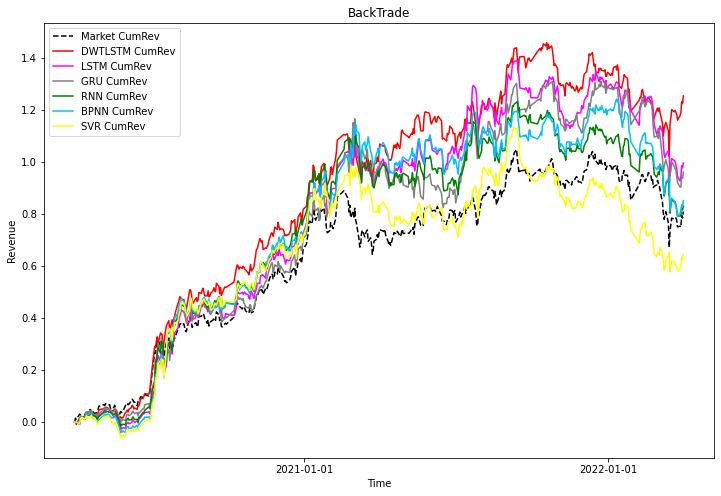

In [88]:
fig = plt.figure(figsize = [12, 8]) #设定图像大小
ax = plt.subplot(111) #设定坐标轴个数
ax.plot(summary['date'], summary['Market_port'], color = 'black', label = 'Market CumRev', linestyle = '--') #市场组合走势
ax.plot(summary['date'], summary['DWTLSTM'], color = 'red', label = 'DWTLSTM CumRev') #基于DWTLSTM算法所构建策略的累计收益率走势
ax.plot(summary['date'], summary['LSTM'], color = 'magenta', label = 'LSTM CumRev') #基于LSTM算法所构建策略的累计收益率走势
ax.plot(summary['date'], summary['GRU'], color = 'grey', label = 'GRU CumRev') #基于GRU算法所构建策略的累计收益率走势
ax.plot(summary['date'], summary['RNN'], color = 'green', label = 'RNN CumRev') #基于RNN算法所构建策略的累计收益率走势
ax.plot(summary['date'], summary['BPNN'], color = 'deepskyblue', label = 'BPNN CumRev') #基于BPNN算法所构建策略的累计收益率走势
ax.plot(summary['date'], summary['SVR'], color = 'yellow', label = 'SVR CumRev') #基于SVR算法所构建策略的累计收益率走势
ax.xaxis.set_major_locator(mdates.YearLocator()) #设定坐标轴刻度
ax.set_title('BackTrade')
ax.set_xlabel('Time')
ax.set_ylabel(f'Revenue')
ax.legend()
plt.show()

### 四、策略收益评价

#### 1.年化收益率

In [89]:
Vf_Vs = summary.iloc[-1, 1:]+1 #Vf:资产终值 Vs：资产初始值 Vf_Vs：Vf/Vs

In [90]:
pd.DataFrame(np.array(Vf_Vs.apply(lambda x: x**(250/487)-1)).T, columns = ['年化收益率'], index = summary.columns[1:]) #回测期共计487天，假定一年中交易日为250天

,年化收益率
DWTLSTM,0.517445
LSTM,0.425749
GRU,0.412817
RNN,0.363648
BPNN,0.371738
SVR,0.291095
Market_port,0.355718


#### 2. 最大回撤率

In [91]:
def get_max_withdraw(indexs): #定义获得最大回撤函数
    max_withdraw = 0 #最大回撤初始值
    max_date_index =0  #初始位置
    last_high = indexs[0] #初始净值

    for index,current in enumerate(indexs):
        # 遍历所有数据
        if current>last_high:
            last_high = current
            continue

        if (last_high-current)/last_high>max_withdraw:
            # 找到一个最大值时，保存其位置
            max_withdraw = (last_high-current)/last_high
            max_date_index=index

    return max_withdraw*100,max_date_index #给出回撤百分比值和回撤位置

In [92]:
max_withdraw_list = ['DWTLSTM', 'LSTM',  'GRU', 'RNN', 'BPNN', 'SVR', 'Market_port'] #构建循环名单
output = []
for colname in max_withdraw_list:
    mw = get_max_withdraw(summary[f'{colname}']+1) #资产真实价格的最大回撤
    output.append(mw)
mw_result = pd.DataFrame(np.array(output)[:, 0], index = max_withdraw_list, columns = ['max_withdraw'])

In [93]:
mw_result

,max_withdraw
DWTLSTM,17.799065
LSTM,19.368968
GRU,19.025689
RNN,19.696671
BPNN,20.094694
SVR,26.066424
Market_port,18.344538


#### 3.年度夏普比率（Annual Sharpe Ratio）

In [94]:
def SR(daily_rev, rf): #无风险利率Rf=0.0335
    SR = (daily_rev.mean() - rf/250)/daily_rev.std() #将每日收益平均值作为期望收益
    return SR

In [95]:
# 市场指数的夏普比率
SR(np.array(mkt['rev']), 0.0335)

0.09406992102966737

In [96]:
# DWTLSTM夏普比率
SR(np.array(DWTLSTM_rev['DWTLSTM_rev']), 0.0335)*(250)**0.5

1.8641840000804455

In [97]:
# LSTM夏普比率
SR(np.array(LSTM_rev['LSTM_rev']), 0.0335)*(250)**0.5

1.6090855555089474

In [98]:
# GRU的夏普比率
SR(np.array(GRU_rev['GRU_rev']), 0.0335)*(250)**0.5

1.4276818936274311

In [99]:
# RNN的夏普比率
SR(np.array(RNN_rev['RNN_rev']), 0.0335)*(250)**0.5

1.3972278061065286

In [100]:
# BPNN的夏普比率
SR(np.array(BPNN_rev['BPNN_rev']), 0.0335)*(250)**0.5

1.353898781341086

In [101]:
# SVR的夏普比率
SR(np.array(SVR_rev['SVR_rev']), 0.0335)*(250)**0.5

1.1014667758971795

#### 4. 胜率

In [102]:
len(mkt[mkt['rev']>0])/len(mkt) #市场组合的胜率

0.5544147843942505

In [103]:
len(DWTLSTM_rev[DWTLSTM_rev['DWTLSTM_rev']>0])/len(DWTLSTM_rev) #DWTLSTM策略的胜率

0.551440329218107

In [104]:
len(LSTM_rev[LSTM_rev['LSTM_rev']>0])/len(LSTM_rev) #LSTM策略的胜率

0.5257731958762887

In [105]:
len(GRU_rev[GRU_rev['GRU_rev']>0])/len(GRU_rev) #GRU策略的胜率

0.554639175257732

In [106]:
len(RNN_rev[RNN_rev['RNN_rev']>0])/len(RNN_rev) #RNN策略的胜率

0.5319587628865979

In [107]:
len(BPNN_rev[BPNN_rev['BPNN_rev']>0])/len(BPNN_rev) #BPNN策略的胜率

0.5402061855670103

In [108]:
len(SVR_rev[SVR_rev['SVR_rev']>0])/len(SVR_rev) #SVR策略的胜率

0.5278350515463918

#### 5&6. Alpha与Beta

In [109]:
from scipy import stats #导入回归库

In [110]:
def alpha_beta(mkt_ret, port_ret):
    beta,alpha,r_value,p_value,std_err=stats.linregress(mkt_ret,port_ret)
    return round(alpha, 6),round(beta, 6)

In [111]:
# DWTLSTM的beta和alpha
alpha_beta(mkt['rev'][-len(DWTLSTM_rev):], DWTLSTM_rev['DWTLSTM_rev'])

(0.000476, 0.996871)

In [112]:
# LSTM的beta和alpha
alpha_beta(mkt['rev'][-len(LSTM_rev):], LSTM_rev['LSTM_rev'])

(0.001434, 0.066197)

In [113]:
# GRU的beta和alpha
alpha_beta(mkt['rev'][-len(GRU_rev):], GRU_rev['GRU_rev'])

(0.000399, 0.870816)

In [114]:
# RNN的beta和alpha
alpha_beta(mkt['rev'][-len(RNN_rev):], RNN_rev['RNN_rev'])

(0.001269, 0.055484)

In [115]:
# BPNN的beta和alpha
alpha_beta(mkt['rev'][-len(BPNN_rev):], BPNN_rev['BPNN_rev'])

(0.001299, 0.059314)

In [116]:
# SVR的beta和alpha
alpha_beta(mkt['rev'][-len(SVR_rev):], SVR_rev['SVR_rev'])

(0.001081, 0.036563)

#### 输出实证回测结果

In [117]:
# 输出准确率预测情况
Accuracy.to_excel(r'C:\Users\admin\Desktop\sz50\0520\Accuracy0520.xlsx')

In [118]:
# 输出精确率预测情况
Precision.to_excel(r'C:\Users\admin\Desktop\sz50\0520\Precision0520.xlsx')

In [119]:
# 输出查全率预测情况
Recall.to_excel(r'C:\Users\admin\Desktop\sz50\0520\Recall0520.xlsx')

In [120]:
# 输出每日配置组合名单
buy_df.to_excel(r'C:\Users\admin\Desktop\sz50\0520\buy_table0520.xlsx')

In [121]:
# 输出累计收益率
summary.to_excel(r'C:\Users\admin\Desktop\sz50\0520\Cumrev_summary0520.xlsx')